<a href="https://colab.research.google.com/github/nsp8/Machine-Learning-Resources/blob/colab-ml-practice/regression_flood_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from google.colab import drive


In [2]:
!pip install ipython-autotime

In [3]:
%load_ext autotime

time: 540 µs (started: 2024-05-31 04:27:11 +00:00)


#### Horizontal Chart for values associated with text labels

In [4]:
class Charts:
    def __init__(self, data, width=18, height=9, font_family="Sans Serif"):
        self.fig, self.ax = plt.subplots(figsize=(width, height))
        self.data = data
        self.y_pos = [i * 0.9 for i in range(len(data))]
        self.ax.barh(
            self.y_pos,
            self.data.values(),
            height=0.55,
            align="edge",
            color="blue",
        )
        self.font_family = font_family

    @property
    def max_data_value(self):
        return max(self.data.values())

    @property
    def min_data_value(self):
        return min(self.data.values())

    @property
    def axis_period(self):
        return int(self.max_data_value) // 10 or 1

    def set_axes(self):
        from math import ceil
        data_size = len(self.data)
        num_ticks = ceil(self.max_data_value)
        self.ax.xaxis.set_ticks([i * self.axis_period for i in range(num_ticks)])
        self.ax.xaxis.set_ticklabels(
            [i * self.axis_period for i in range(0, num_ticks)],
            size=16,
            fontfamily=self.font_family,
            fontweight=100,
        )
        self.ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)
        self.ax.set_axisbelow(True)
        self.ax.grid(axis="x", color="#8C92AC", lw=1.2)
        self.ax.spines["left"].set_visible(False)
        self.ax.spines["right"].set_visible(False)
        self.ax.spines["top"].set_visible(False)
        self.ax.spines["bottom"].set_visible(False)
        self.ax.spines["left"].set_lw(1.5)
        self.ax.spines["left"].set_capstyle("butt")
        self.ax.yaxis.set_visible(False)
        return self

    def add_bar_text(self, label_object: dict):
        self.ax.text(
            x=label_object["x_pos"],
            y=label_object["y_pos"],
            s=label_object["text"],
            c=label_object["color"],
            fontfamily=self.font_family,
            fontsize=12,
            va="center",
            path_effects=label_object["path_effects"],
        )

    def add_labels(self, padding: float = 0.3):
        offset = 0.04
        for label, value, y_pos in zip(
            self.data.keys(), self.data.values(), self.y_pos
        ):
            metric_label = dict(
                x_pos=int(self.min_data_value) + (padding * 2.2),
                y_pos=(y_pos + 0.25),
                text=label,
                color="white",
                path_effects=[withStroke(linewidth=6, foreground="green")]
            )
            value_label = dict(
                x_pos=value,
                y_pos=(y_pos + 0.25),
                text=f"{round(value, 3)}0",
                color="green",
                path_effects=[withStroke(linewidth=6, foreground="white")]
            )
            if value < 0:
                metric_label["x_pos"] = self.min_data_value - (padding * 0.7) - offset
                metric_label["path_effects"] = [withStroke(linewidth=6, foreground="red")]
                metric_label["color"] = "white"
                value_label["color"] = "red"
                value_label["x_pos"] -= offset
            self.add_bar_text(metric_label)
            self.add_bar_text(value_label)

        return self

    def add_title(self, title, pos=0.5):
        self.fig.text(
            pos, 0.925, title, fontsize=16, fontweight="bold", fontfamily=self.font_family
        )
        return self

    def plot(self, title=None):
        self.set_axes().add_labels()
        if title:
            self.add_title(title)
        plt.show()


time: 3.69 ms (started: 2024-05-31 04:27:11 +00:00)


In [5]:
drive.mount('/gdrive/')

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
time: 795 ms (started: 2024-05-31 04:27:11 +00:00)


### **Data Loading**

In [6]:
base_folder_path = os.path.join('/gdrive', 'My Drive', 'Projects', 'ML Practice', 'Regression: flood prediction', 'data')
if os.path.exists(base_folder_path):
    print("Loading data ...")
    train_data = pd.read_csv(os.path.join(base_folder_path, "train.csv"))
    test_data = pd.read_csv(os.path.join(base_folder_path, "test.csv"))
    print("Loaded train and test files from Drive")
else:
    raise FileNotFoundError("Could not locate files")

Loading data ...
Loaded train and test files from Drive
time: 23 s (started: 2024-05-31 04:27:12 +00:00)


## **Data Exploration**

### Basic statistical analyses

In [7]:
train_data.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


time: 2.66 s (started: 2024-05-31 04:27:35 +00:00)


In [8]:
# Null counts
train_data.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

time: 57.2 ms (started: 2024-05-31 04:27:37 +00:00)


In [9]:
# Data type information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

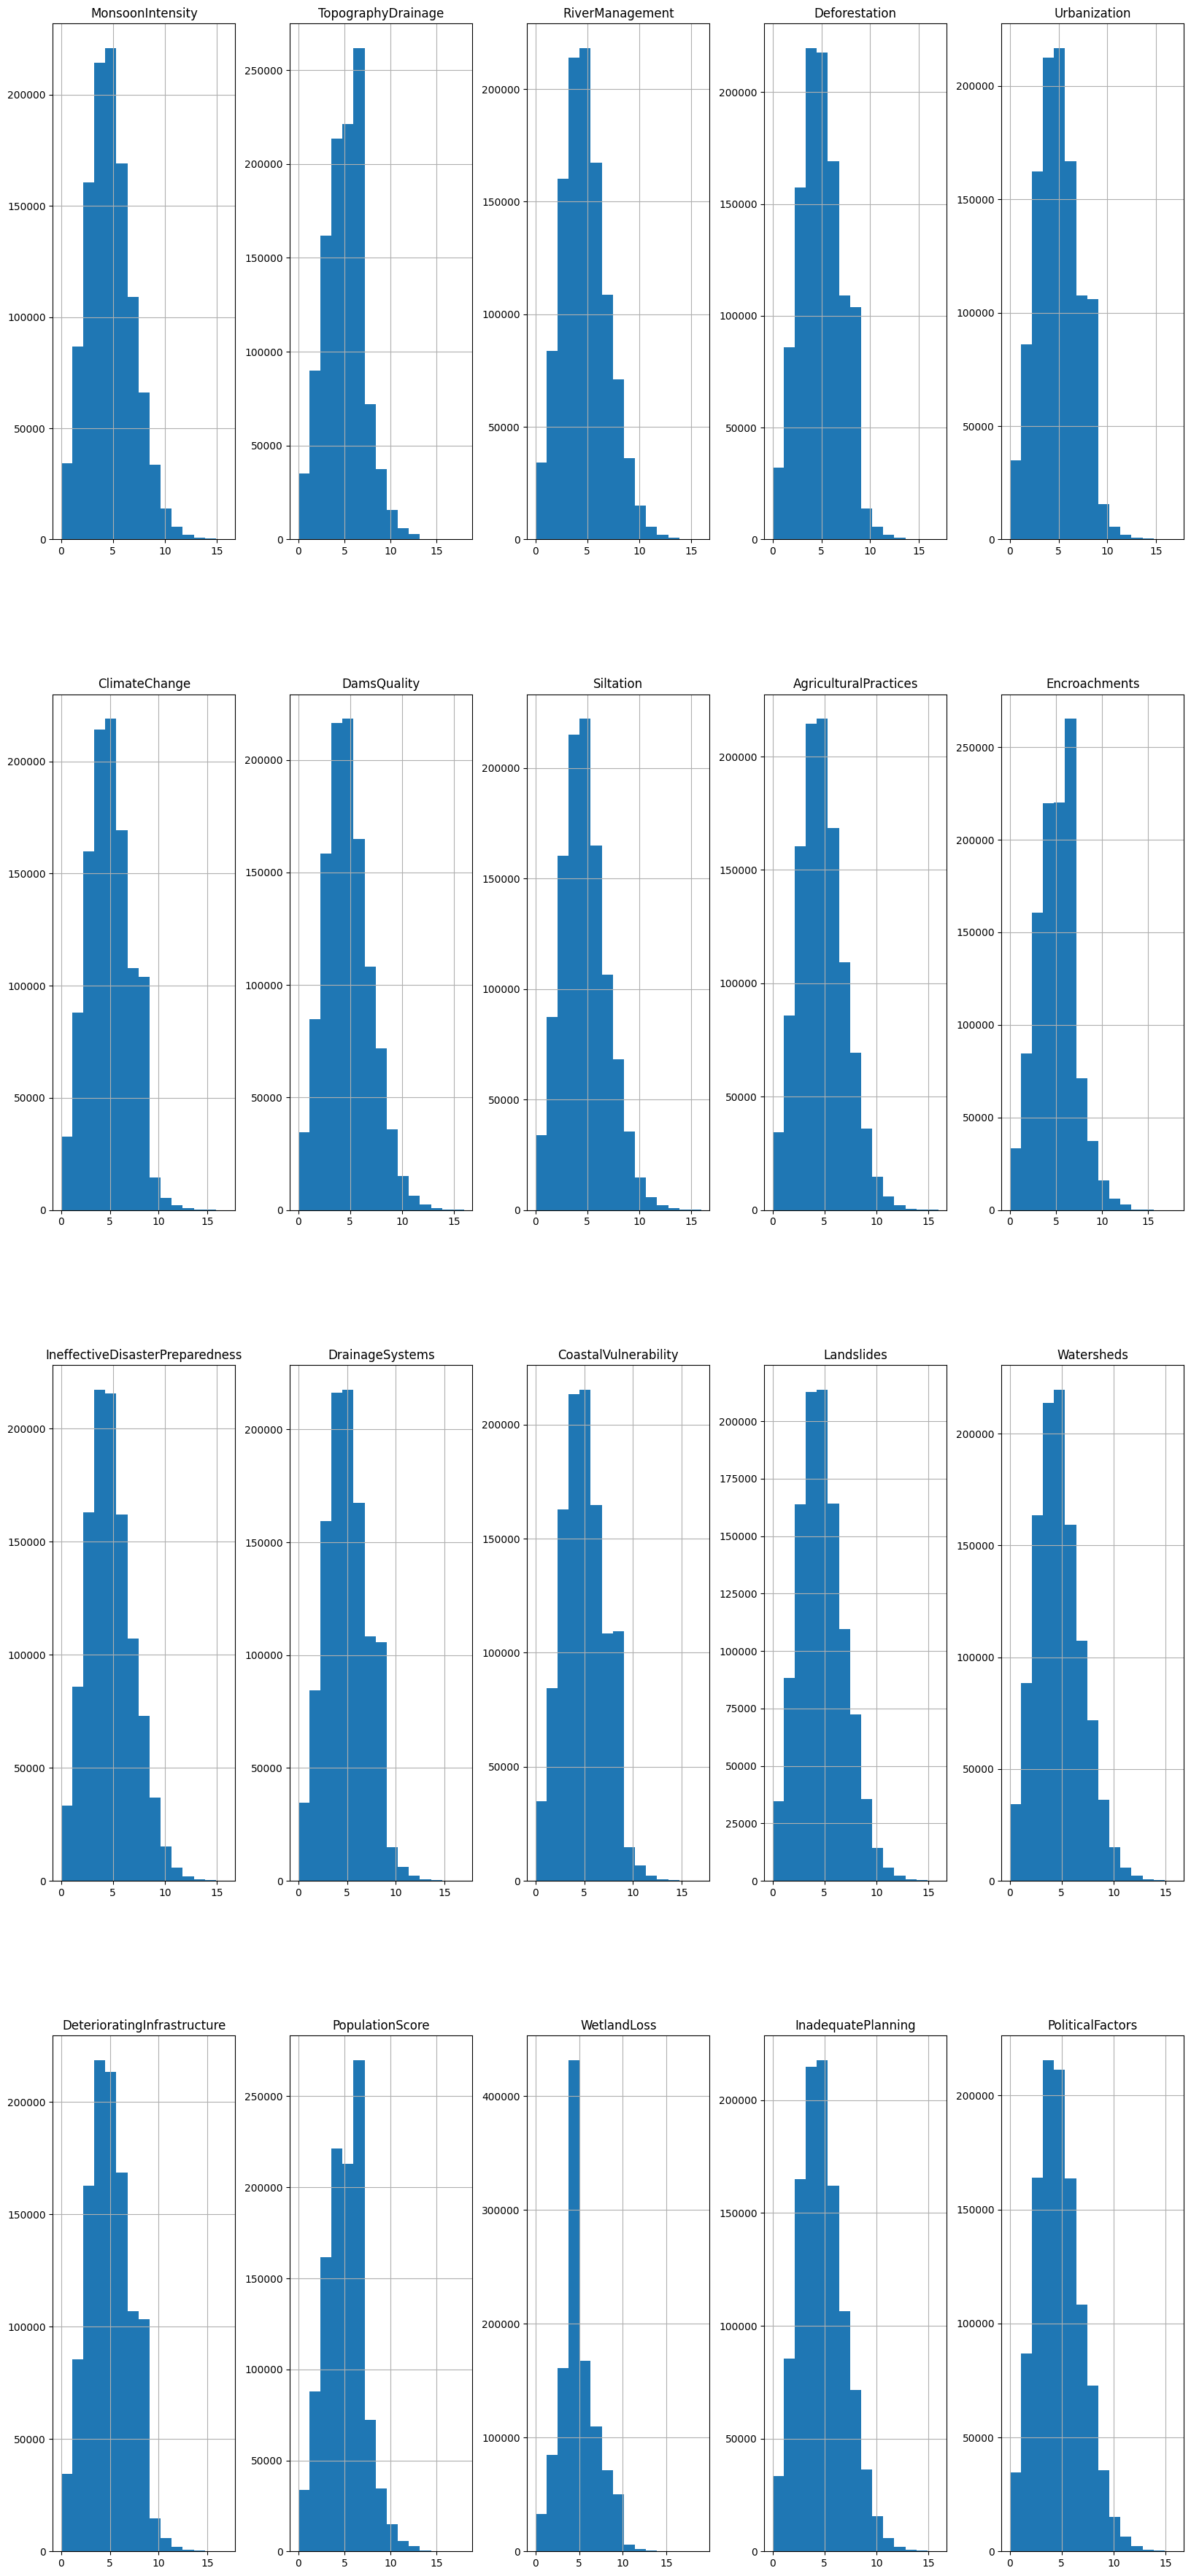

time: 14.9 s (started: 2024-05-31 04:27:37 +00:00)


In [10]:
# Layout of data
features_train = train_data.set_index("id")
target_column = "FloodProbability"
label_train = features_train.pop(target_column)
features_train.hist(bins=15, figsize=(20, 45), layout=(4, 5))

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

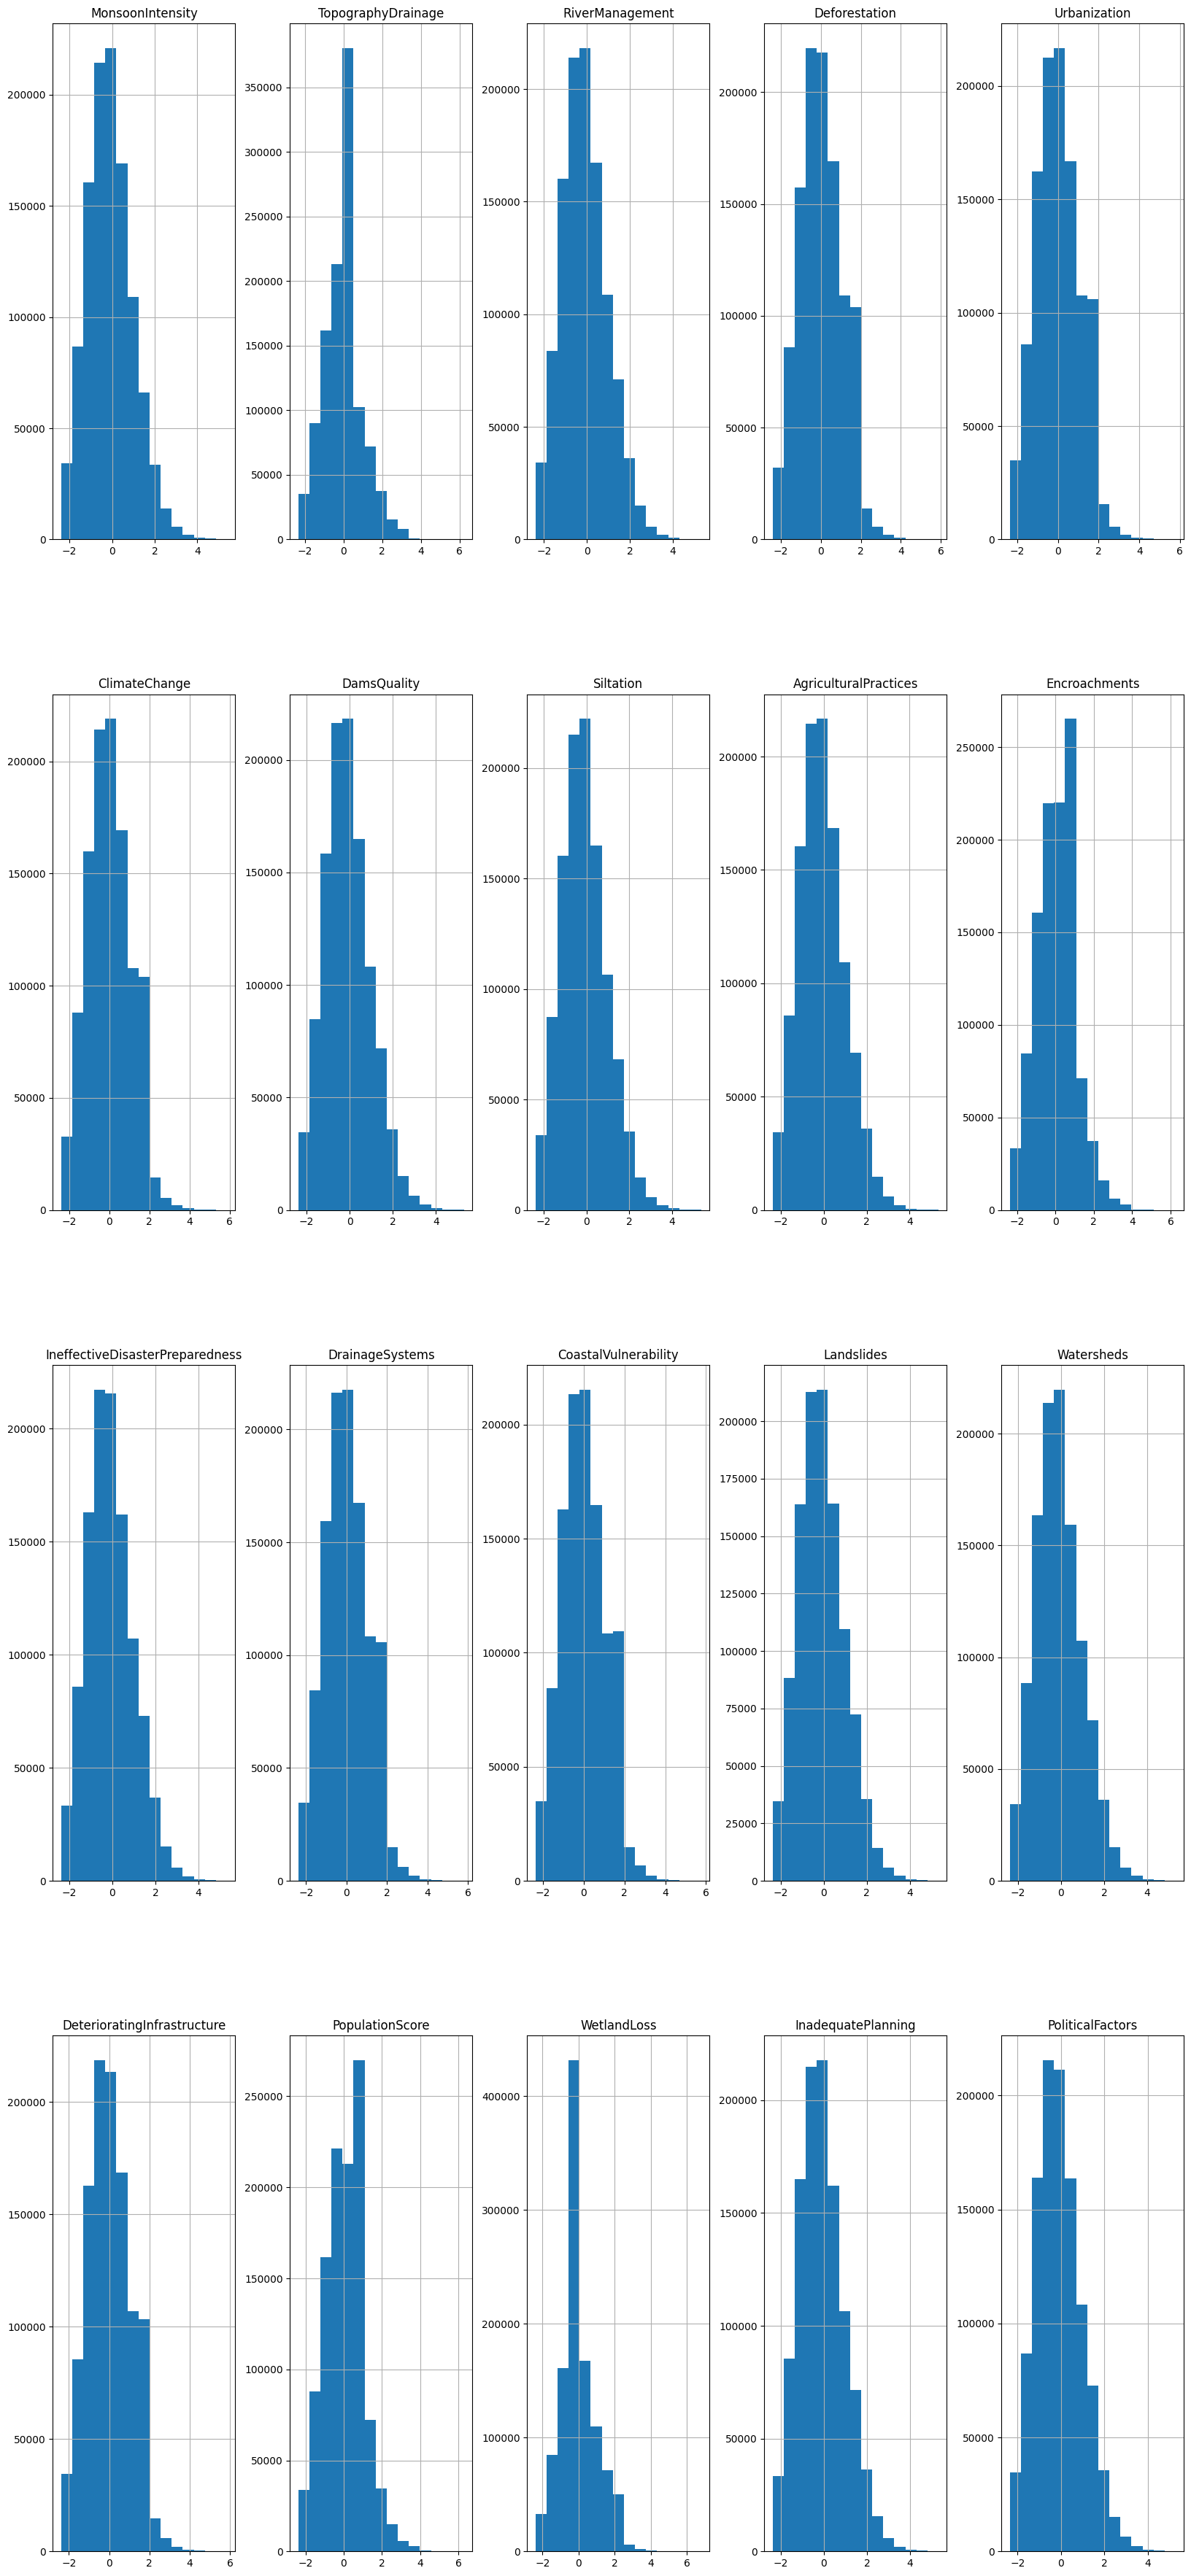

time: 16.7 s (started: 2024-05-31 04:27:52 +00:00)


In [11]:
# Standardizing data

def standardize(data):
    standard_scaler = StandardScaler()
    standard_scaler.fit(data)
    return standard_scaler.transform(data)
    # _data = data.copy(deep=True)
    # return (_data - _data.mean(axis=0)) / _data.std(axis=0)


features_train_standardized = pd.DataFrame(standardize(features_train), columns=features_train.columns)
features_train_standardized.hist(bins=15, figsize=(20, 45), layout=(4, 5))
# print(features_train_standardized.shape)

array([[<Axes: title={'center': 'FloodProbability'}>]], dtype=object)

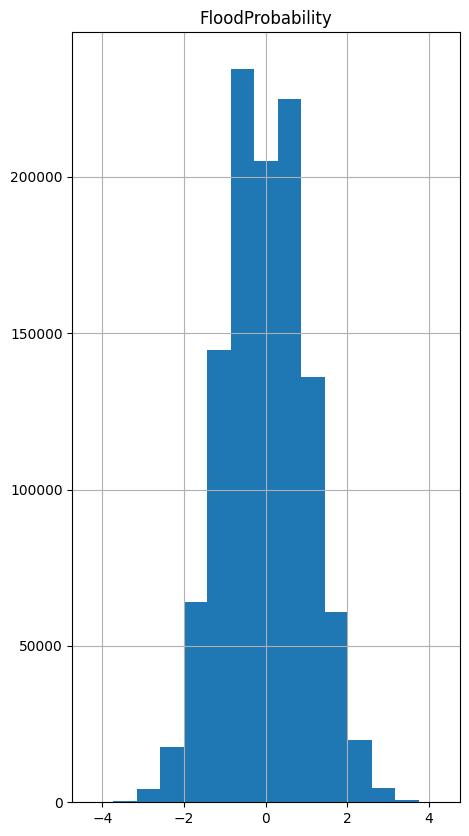

time: 1.02 s (started: 2024-05-31 04:28:09 +00:00)


In [12]:
def standardize_labels(label_data):
    mean, std = label_data.mean(), label_data.std()
    return label_data.apply(lambda v: (v - mean) / std)


label_train_standardized = pd.DataFrame(standardize_labels(label_train), columns=[target_column])
label_train_standardized.hist(bins=15, figsize=(5, 10))

#### Train test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features_train_standardized, label_train_standardized, test_size=0.25)

time: 623 ms (started: 2024-05-31 04:28:10 +00:00)


In [14]:
X_train.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')

time: 5.09 ms (started: 2024-05-31 04:28:11 +00:00)


#### Correlation matrix of training features

<Axes: >

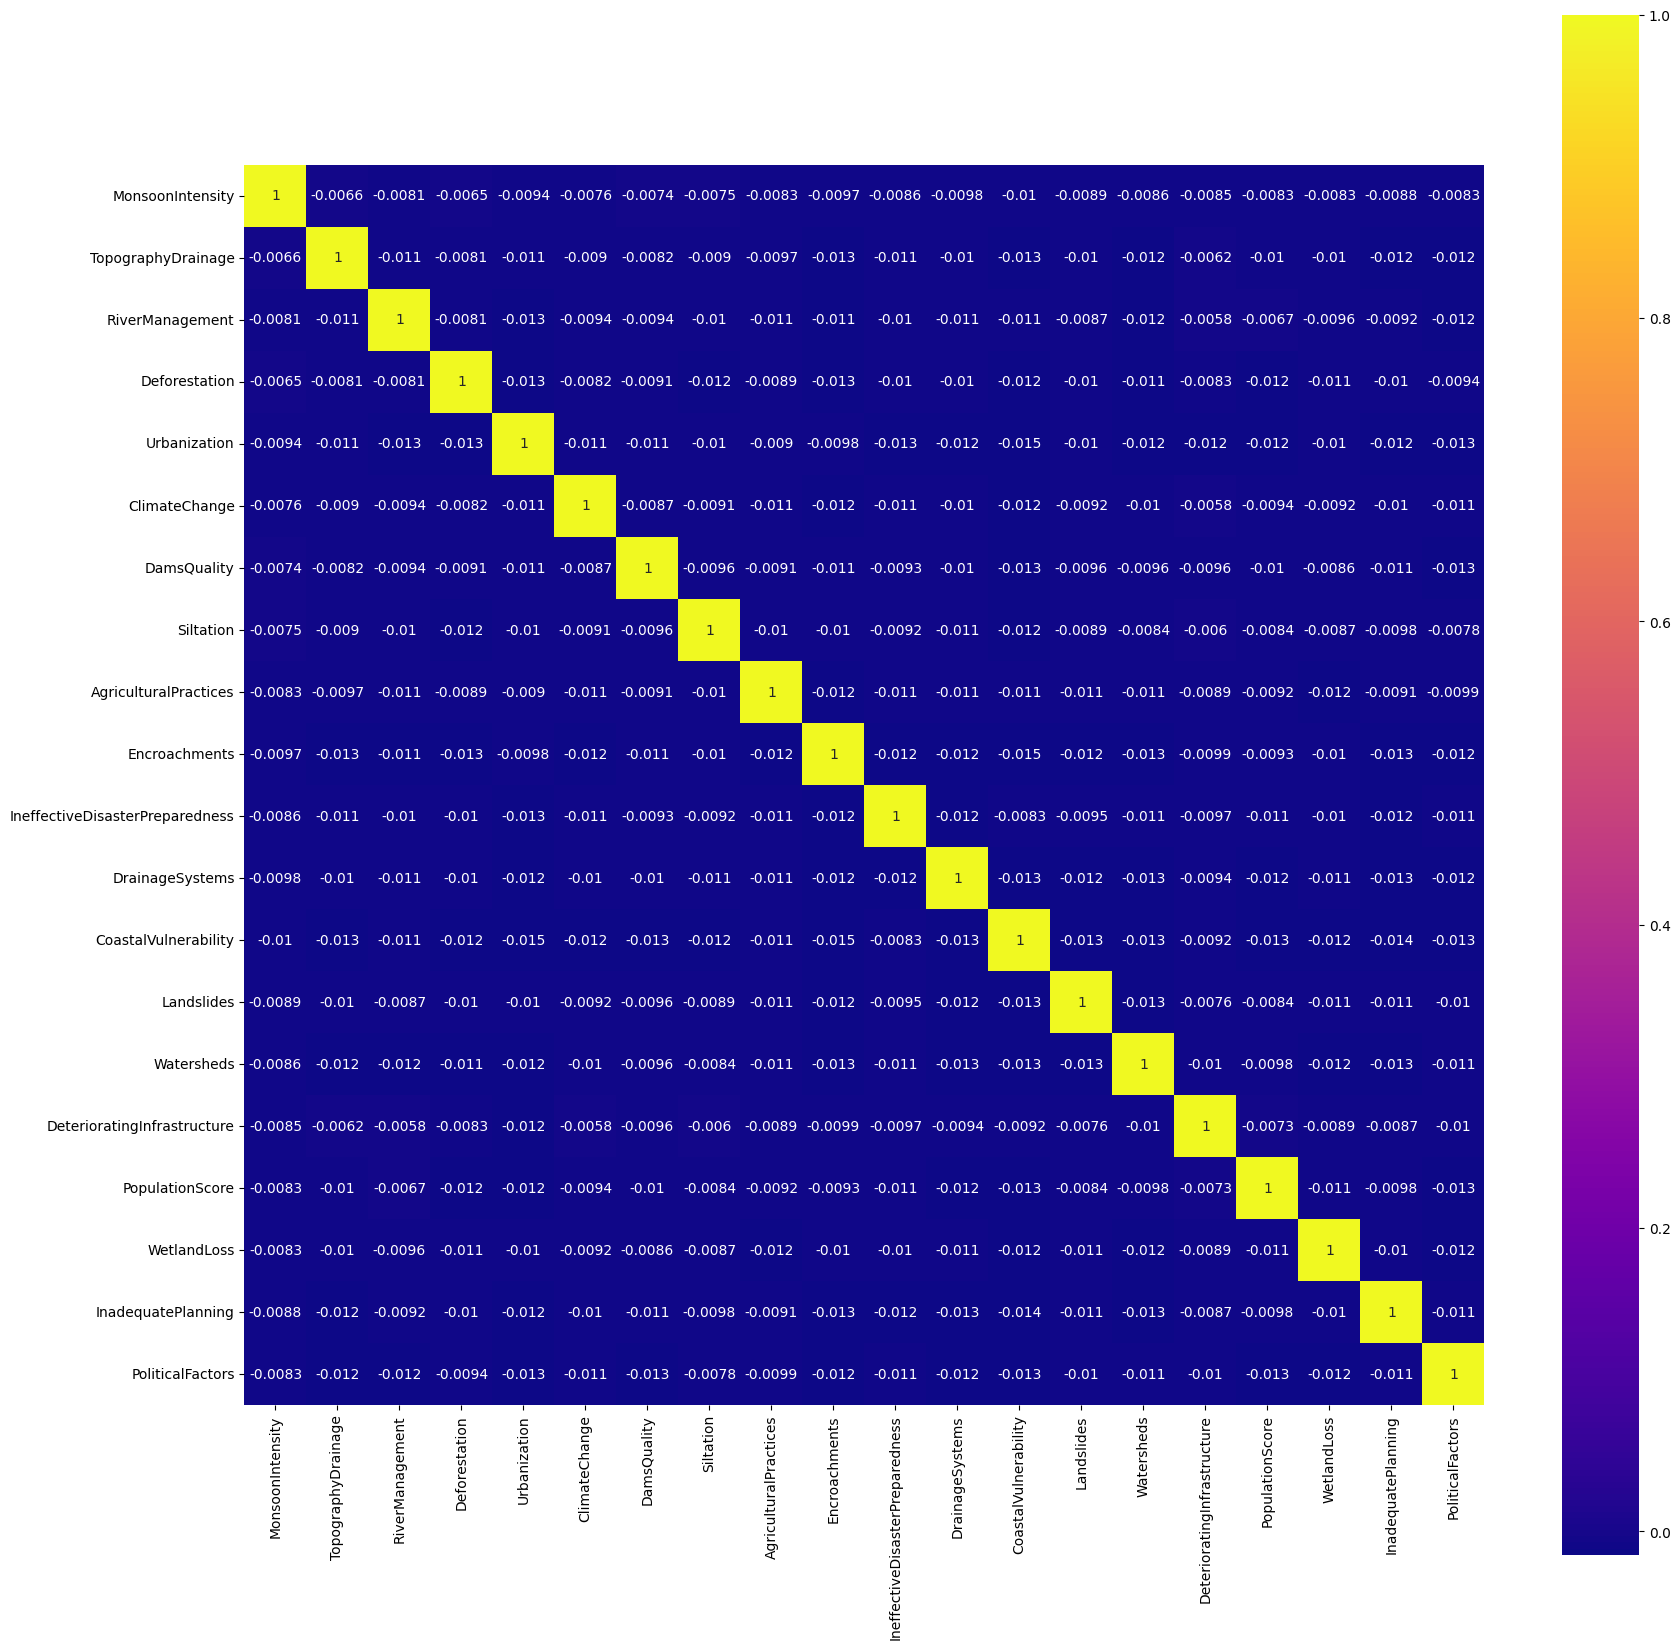

time: 3.12 s (started: 2024-05-31 04:28:11 +00:00)


In [15]:
plt.figure(figsize=(20, 20))
sns.heatmap(X_train.corr(), vmax=1, square=True, annot=True, cmap="plasma")

### Feature Analyses


-----------------------------------
PCA Loadings 
-----------------------------------

                                      PC1       PC2       PC3       PC4  \
MonsoonIntensity                 0.009132 -0.054459  0.154354  0.075328   
TopographyDrainage              -0.021854 -0.187365  0.312014 -0.145259   
RiverManagement                 -0.004664 -0.405086 -0.290714 -0.118991   
Deforestation                    0.193245 -0.371592  0.368390  0.213795   
Urbanization                    -0.356224  0.395479  0.204615  0.069124   
ClimateChange                   -0.032615 -0.241089  0.074932 -0.174159   
DamsQuality                     -0.048416 -0.043301  0.227857 -0.258392   
Siltation                       -0.077734  0.172539 -0.190476  0.022228   
AgriculturalPractices           -0.005732  0.120521  0.107635  0.357231   
Encroachments                   -0.378908  0.266067 -0.095106 -0.156513   
IneffectiveDisasterPreparedness  0.396153  0.222528 -0.124021 -0.093281   
DrainageSyst

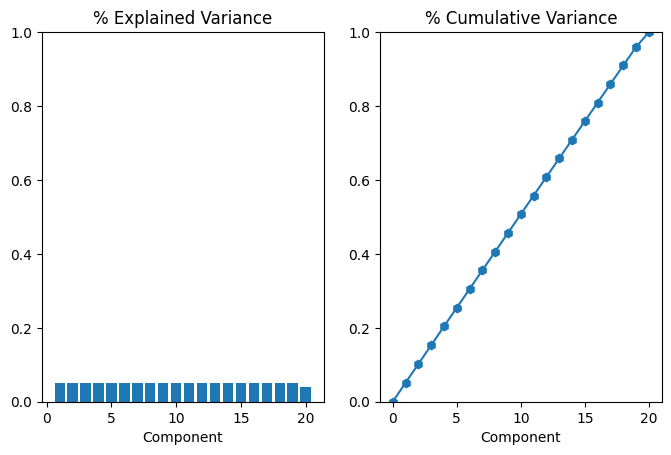

time: 5.31 s (started: 2024-05-31 04:28:14 +00:00)


In [16]:
class FeatureAnalyzer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.pca = PCA()
        self.pca.fit_transform(self.X)

    @property
    def X_pca(self):
        x_pca = self.pca.fit_transform(self.X)
        return pd.DataFrame(x_pca, columns=[f"PC{i+1}" for i in range(x_pca.shape[1])])

    @property
    def pca_loadings(self):
        return pd.DataFrame(self.pca.components_.T, columns=self.X_pca.columns, index=self.X.columns)

    def plot_variance(self, width=8, dpi=100):
        fig, axes = plt.subplots(1, 2)
        n = self.pca.n_components_
        print(f"\n{'-' * 35}\nPCA Loadings \n{'-' * 35}\n")
        print(self.pca_loadings)
        grid = np.arange(1, n+1)
        explained_variance = self.pca.explained_variance_ratio_
        axes[0].bar(grid, explained_variance)
        axes[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
        cumulative_variance = np.cumsum(explained_variance)
        axes[1].plot(np.r_[0, grid], np.r_[0, cumulative_variance], marker="h")
        axes[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
        fig.set(figwidth=width, dpi=dpi)
        return axes

    def make_mi_scores(self, discrete_features: bool = False):
        mi_regression = mutual_info_regression(self.X, self.y, discrete_features=discrete_features)
        return pd.Series(mi_regression, name="Mutual Info Scores", index=self.X.columns).sort_values(ascending=False)

    def check_outliers(self):
        sns.catplot(
            y="value",
            col="variable",
            data=self.X_pca.melt(),
            kind="boxen",
            sharey=False,
            col_wrap=2
        )


def show_feature_analysis_artifacts(X, y, show_mi_scores=True, show_outliers=True):
    feature_analyzer = FeatureAnalyzer(X, y)
    feature_analyzer.plot_variance()
    if show_mi_scores:
        mi_scores = feature_analyzer.make_mi_scores()
        print(f"\n{'-' * 35}\nMutual Information Scores \n{'-' * 35}\n")
        print(mi_scores)
    if show_outliers:
        feature_analyzer.check_outliers()
    return feature_analyzer


feature_analyzer_object = show_feature_analysis_artifacts(
    X_train, y_train, show_mi_scores=False, show_outliers=False
)

In [17]:
feature_analyzer_object.pca_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
MonsoonIntensity,0.009132,-0.054459,0.154354,0.075328,0.168981,-0.142448,-0.129910,0.031595,-0.141622,-0.176626,-0.281472,-0.172747,0.204783,0.676171,-0.101833,0.164742,0.135456,0.346472,0.179879,0.181686
TopographyDrainage,-0.021854,-0.187365,0.312014,-0.145259,0.167268,-0.079032,-0.073948,0.288962,0.434338,-0.125655,-0.332989,-0.117453,0.085030,-0.092737,-0.091560,-0.299012,-0.363164,-0.089182,-0.303746,0.218936
RiverManagement,-0.004664,-0.405086,-0.290714,-0.118991,-0.162343,-0.023836,0.082282,-0.045276,-0.262914,-0.053420,0.055522,-0.502964,-0.093641,-0.168552,-0.109240,0.356536,-0.222868,0.158740,-0.278079,0.212147
Deforestation,0.193245,-0.371592,0.368390,0.213795,-0.025841,-0.059720,-0.034566,0.076313,-0.325626,-0.253302,0.039339,-0.022879,0.049643,-0.264761,0.028355,-0.103372,0.459956,-0.333950,0.071636,0.217650
Urbanization,-0.356224,0.395479,0.204615,0.069124,-0.161891,-0.070212,0.026545,0.150354,0.185589,-0.237697,0.415459,-0.279560,0.180412,-0.070783,-0.116692,0.251562,-0.095207,-0.175748,0.243082,0.245771
ClimateChange,-0.032615,-0.241089,0.074932,-0.174159,0.206625,0.155078,-0.055169,-0.113825,0.053414,-0.205242,0.367120,0.535903,0.181549,0.146215,0.256414,0.334829,-0.133659,-0.003898,-0.246514,0.210547
DamsQuality,-0.048416,-0.043301,0.227857,-0.258392,0.058538,-0.442211,-0.108773,-0.040664,-0.120758,0.373481,-0.016752,0.231004,-0.466004,0.024577,-0.244185,0.210030,-0.129595,-0.170162,0.211421,0.212056
Siltation,-0.077734,0.172539,-0.190476,0.022228,0.363949,0.257924,-0.132819,-0.030982,0.277346,0.138458,-0.227214,-0.103207,-0.123010,-0.081660,-0.144675,0.355489,0.489626,-0.216031,-0.235028,0.201777
AgriculturalPractices,-0.005732,0.120521,0.107635,0.357231,-0.169860,-0.263436,0.381780,0.162463,0.174250,-0.002169,-0.120254,0.119549,-0.313878,-0.068411,0.420067,0.155042,0.119961,0.337403,-0.194316,0.216880
Encroachments,-0.378908,0.266067,-0.095106,-0.156513,-0.288530,0.080258,-0.075654,-0.039979,-0.360335,-0.261127,-0.345816,0.356683,0.056140,-0.168239,-0.220308,-0.136850,0.049046,0.129028,-0.173405,0.249800


time: 1.55 s (started: 2024-05-31 04:28:19 +00:00)


#### Visualize principal components

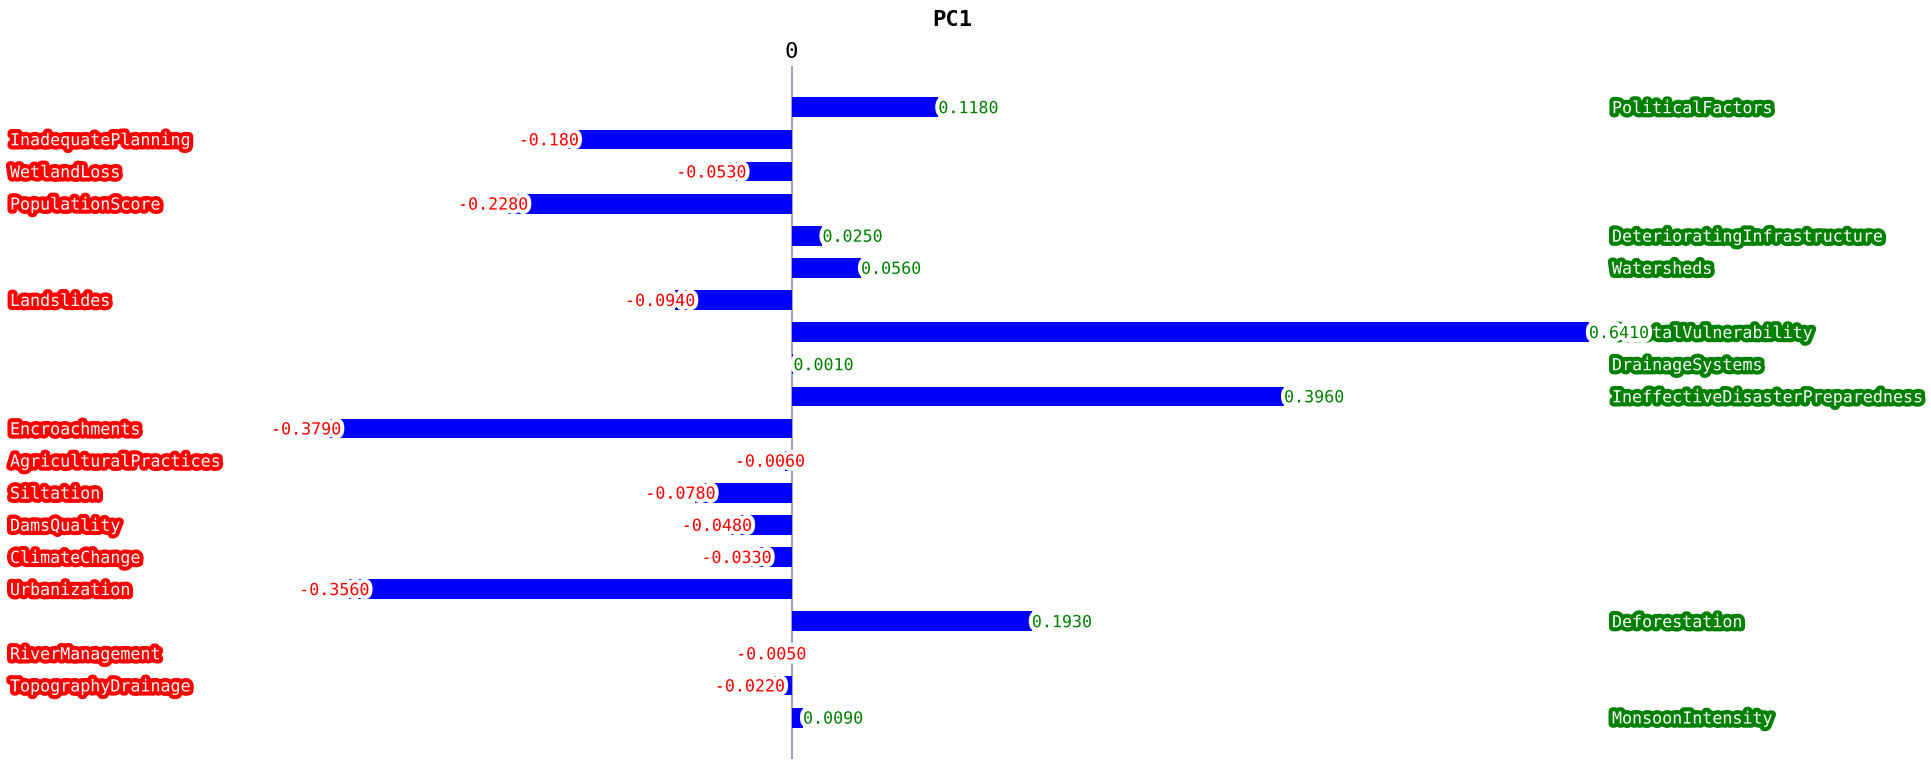

time: 1.62 s (started: 2024-05-31 04:28:21 +00:00)


In [18]:
def plot_principal_component(feature_analyzer_object, level=1):
    if level < 1:
        raise ValueError("PC level can't be less than 1")
    _loadings = feature_analyzer_object.pca_loadings
    _column = _loadings.columns[level - 1]
    pc_dataframe = _loadings.loc[:, _column].reset_index().to_dict(orient="records")
    feature_to_pc1 = {_entry["index"]: float(_entry[_column]) for _entry in pc_dataframe}
    chart = Charts(data=feature_to_pc1, font_family="monospace")
    chart.plot(title=_column)

plot_principal_component(feature_analyzer_object, level=1)

#### Adding new features [test]

In [19]:
X_train_new = X_train.copy(deep=True)
X_train_new["IsCoastalVulnerability"] = X_train["CoastalVulnerability"] > 0
X_train_new["IsIneffectiveDisasterPreparedness"] = X_train["IneffectiveDisasterPreparedness"] > 0
X_train_new["IsDeforestation"] = X_train["Deforestation"] > 0
X_test_new = X_test.copy(deep=True)
X_test_new["IsCoastalVulnerability"] = X_test["CoastalVulnerability"] > 0
X_test_new["IsIneffectiveDisasterPreparedness"] = X_test["IneffectiveDisasterPreparedness"] > 0
X_test_new["IsDeforestation"] = X_test["Deforestation"] > 0

time: 155 ms (started: 2024-05-31 04:28:23 +00:00)


## **Training the model: XGBoost Regressor**

In [20]:
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor


class RegressionModel:
    def __init__(
        self,
        train_data: tuple,
        test_data: tuple,
        learning_rate=0.01,
        n_estimators=1000,
        early_stopping_rounds=5,
        corss_validation_folds=10,
        n_jobs=1
    ):
        self.model = XGBRegressor()
        self.train_data = train_data
        self.test_data = test_data
        self.learning_curve_params = {
            "X": train_data[0],
            "y": train_data[1],
            "train_sizes": np.linspace(0.1, 1, 10),
            "cv": corss_validation_folds,
            "n_jobs": n_jobs
        }
        self.validation_curve_params = {
            "X": train_data[0],
            "y": train_data[1],
            "cv": corss_validation_folds,
            "param_name": "regressor__learning_rate",
            "param_range": np.linspace(0.0001, 0.1, 100),
            "n_jobs": n_jobs
        }

    @property
    def pipeline(self):
        return make_pipeline(self.model)

    def set_model(self, model_class):
        self.model = model_class()

    def plot_learning_curve(self, curve_function="learning_curve"):
        def plot(data_sizes, scores, plot_params):
            data_average = np.mean(scores, axis=1)
            data_std = np.std(scores, axis=1)
            plt.plot(
                data_sizes,
                data_average,
                **plot_params
            )
            plt.fill_between(
                data_sizes,
                data_average + data_std,
                data_average - data_std,
                alpha=0.15,
                color=plot_params["color"]
            )
        if curve_function == "learning_curve":
            train_sizes, train_scores, test_scores = learning_curve(
                estimator=self.pipeline,
                **self.learning_curve_params
            )
            plt.xlabel("Number of training examples")
        else:
            train_scores, test_scores = validation_curve(
                estimator=self.pipeline,
                **self.validation_curve_params
            )
            train_sizes = self.validation_curve_params["param_range"]
            plt.xlabel("XGBRegressor learning rate")
        plot(train_sizes, train_scores, dict(color="blue", marker="o", markersize=5, label="Training accuracy"))
        plot(train_sizes, test_scores, dict(color="red", marker="s", linestyle="--", markersize=5, label="Validation accuracy"))
        plt.grid()

        plt.ylabel("Accuracy")
        plt.legend(loc="upper right")
        # plt.ylim([0.8, 1.03])
        plt.show()

time: 38.5 ms (started: 2024-05-31 04:28:23 +00:00)


In [21]:
models = list()

time: 524 µs (started: 2024-05-31 00:41:59 +00:00)


In [ ]:
model = RegressionModel(train_data=(X_train, y_train), test_data=(X_test, y_test))
model.plot_learning_curve(learning_curve)
model.plot_learning_curve(validation_curve)
models.append(model)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x78646be37040>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


In [ ]:
model = RegressionModel(train_data=(X_train_new, y_train), test_data=(X_test_new, y_test))
model.plot_learning_curve(learning_curve)
model.plot_learning_curve(validation_curve)
models.append(model)

#### Adding features based on the PCA

In [22]:
X_train_pca = feature_analyzer_object.pca.fit_transform(X_train)
X_test_pca = feature_analyzer_object.pca.fit_transform(X_test)
model = RegressionModel(train_data=(X_train_pca, y_train), test_data=(X_test_pca, y_test))
model.plot_learning_curve(learning_curve)
model.plot_learning_curve(validation_curve)
models.append(model)

KeyboardInterrupt: 

time: 59min 59s (started: 2024-05-31 01:13:11 +00:00)


In [21]:
X_train_pca = feature_analyzer_object.pca.fit_transform(X_train)
X_test_pca = feature_analyzer_object.pca.transform(X_test)
# model = RegressionModel(train_data=(X_train_pca, y_train), test_data=(X_test_pca, y_test))
# model.plot_learning_curve(learning_curve)
# model.plot_learning_curve(validation_curve)
# models.append(model)

time: 1.36 s (started: 2024-05-31 04:28:36 +00:00)


### **Training the model: SVM Regressor**

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.svm import SVR


svr_param_grid = [
    {
        "svr__C": np.linspace(0.0001, 1000.0, 10),
        "svr__kernel": ["linear"],
    },
    {
        "svr__C": np.linspace(0.0001, 1000.0, 10),
        "svr__gamma": np.linspace(0.0001, 1000.0, 10),
        "svr__kernel": ["rbf"],
    }
]

svr_pipeline = make_pipeline(SVR())
halving_random_search = HalvingRandomSearchCV(
    estimator=svr_pipeline,
    param_distributions=svr_param_grid,
    n_candidates="exhaust",
    resource="n_samples",
    factor=1.5,
    n_jobs=2
)
random_search = halving_random_search.fit(X_train_pca, y_train)
print(f"{random_search.best_score_=}\n{random_search.best_params_}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 110 is smaller than n_iter=83846. Running 110 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [        nan  

In [ ]:
svr_estimator = random_search.best_estimator_
print(f"Test accuracy: {random_search.score(X_test_pca, y_test):.4f}")